**Implementação de algoritmos de decomposição de dados em um conjunto de dados de imagem (fotos de rostos humanos reais).**

**Etapa 1 - Carregamento e pré-processamento**

In [ ]:
import logging

import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn import cluster, decomposition
from sklearn.datasets import fetch_olivetti_faces

rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (focus on one sample, centering all features)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


Aqui, começamos importando as bibliotecas e o dataset para o ambiente.

As imagens passam a ser representadas em formato matricial (nº de imagens, nº de pixels por imagem), ou seja, temos uma matriz em que cada linha representa uma imagem, e cada coluna representa um pixel de uma "posição" específica.

Foi aplicado a centralização global e local, a fim de preparar as amostras para os algoritmos que serão implementados em seguida.

Pra entender melhor a centralização, pode ser interessante visualizar essa "imagem média":

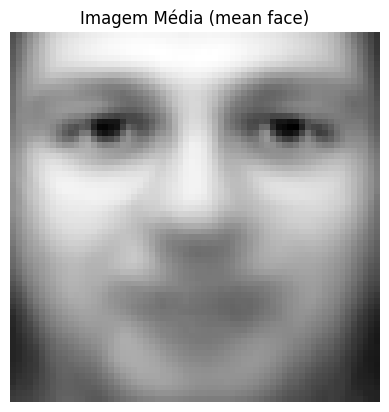

In [ ]:
# Calcular o valor médio de cada pixel (vetor de 4096 elementos)
mean_face = faces.mean(axis=0)

# Remodelar esse vetor para o formato original da imagem (64x64)
mean_face_image = mean_face.reshape(64, 64)

# Plotar a face média
plt.imshow(mean_face_image, cmap="gray")
plt.title("Imagem Média (mean face)")
plt.axis("off")
plt.show()


Aqui abaixo, mais uma etapa de preparação, apenas configurando a formatação dos plots das imagens que virão e definindo o número base de componentes (6)

In [ ]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

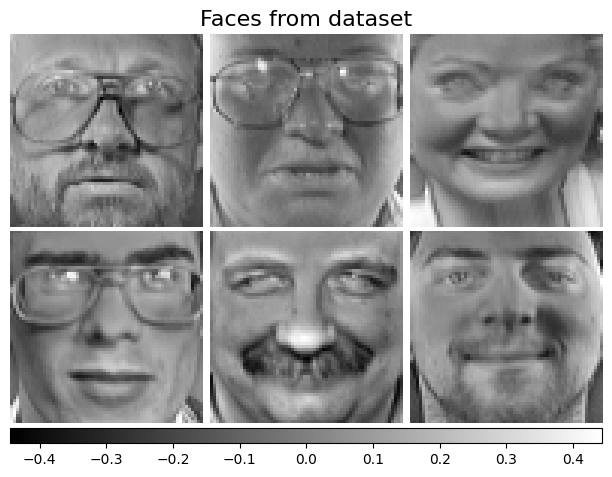

In [ ]:
plot_gallery("Faces from dataset", faces_centered[:n_components])

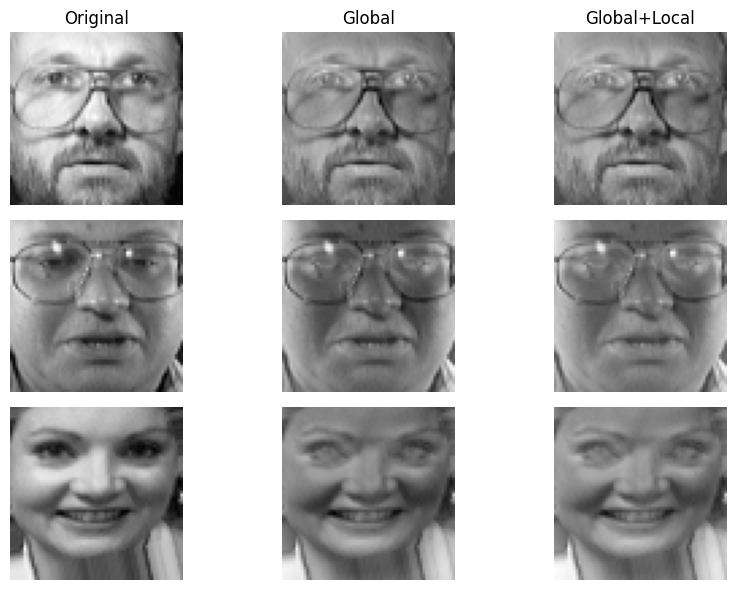

In [ ]:
import numpy as np

# Centralizações
faces_centered_global = faces - faces.mean(axis=0)
faces_centered_local = faces_centered_global - faces_centered_global.mean(axis=1).reshape(n_samples, 1)

# Escolher 3 imagens
indices = [0, 1, 2]

# Plotar a comparação
fig, axes = plt.subplots(len(indices), 3, figsize=(9, 6))

for row, idx in enumerate(indices):
    # Original
    img_original = faces[idx].reshape(64, 64)
    axes[row, 0].imshow(img_original, cmap="gray")
    axes[row, 0].set_title("Original" if row == 0 else "")
    axes[row, 0].axis("off")

    # Após centralização global
    img_global = faces_centered_global[idx].reshape(64, 64)
    vmax = np.abs(img_global).max()
    axes[row, 1].imshow(img_global, cmap="gray", vmin=-vmax, vmax=vmax)
    axes[row, 1].set_title("Global" if row == 0 else "")
    axes[row, 1].axis("off")

    # Após centralização local
    img_local = faces_centered_local[idx].reshape(64, 64)
    vmax = np.abs(img_local).max()
    axes[row, 2].imshow(img_local, cmap="gray", vmin=-vmax, vmax=vmax)
    axes[row, 2].set_title("Global+Local" if row == 0 else "")
    axes[row, 2].axis("off")

plt.tight_layout()
plt.show()


Nessa comparação, podemos notar os efeitos da centralização nas imagens originais. A última coluna representa a forma "final" das imagens após o pré-processamento, prontas para a implementação dos algoritmos.

---------------------------------------------------------------------------


**DECOMPOSIÇÃO**

Sucintamente, são formas de representar os dados originais (nesse caso, as imagens de rostos) como uma mistura de padrões gerais/básicos aprendidos a partir do dataset.

Cada algoritmo fornece uma perspectiva diferente sobre uma mesma base de dados, mas de forma geral, extraem os padrões dominantes de variação, no nosso caso, dos rostos das imagens.

Dessa forma, é útil para a **redução de dimensionalidade**, por exemplo, e pode servir como uma etapa de pré-processamento para outros algoritmos.

------------------------------------------------------------------------------

**1) PCA - SVD randomizado**

O algoritmo encontra, a partir das imagens pré-processadas, padrões globais de variação **(eigenfaces)**, sendo uma qtde pré-definida - no nosso caso, foi definido como 6 lá atrás.

Cada imagem original tem um peso associado a cada eigenface. Dessa forma, ao recombinar as eigenfaces com os pesos equivalentes, é possível reconstruir os rostos do daatset de forma aproximada - quanto maior o peso associado a eigenface, maior a contribuição daquela eigenface para reconstruir a imagem

SVD vem de Singular Value Decomposition, e quando usamos o SVD randomizado no algoritmo do PCA, estamos calculando, de uma forma aproximada mas muito mais rápida e menos custosa, os componentes principais. Em vez de decompor toda a matriz de covariância, ele usa vetores aleatórios para estimar apenas as direções de maior variância, o que é essencial quando trabalhamos com dados de alta dimensionalidade.

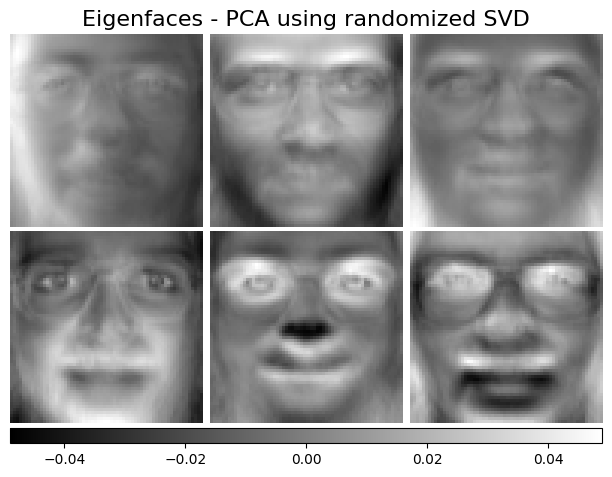

In [ ]:
pca_estimator = decomposition.PCA(n_components=n_components, svd_solver="randomized", whiten=True)
pca_estimator.fit(faces_centered)
plot_gallery("Eigenfaces - PCA using randomized SVD", pca_estimator.components_[:n_components])

No nosso exemplo, essas são as 6 eigenfaces extraídas de faces_centered. Podemos testar e verificar quanto do dataset original conseguimos "varrer" com elas:

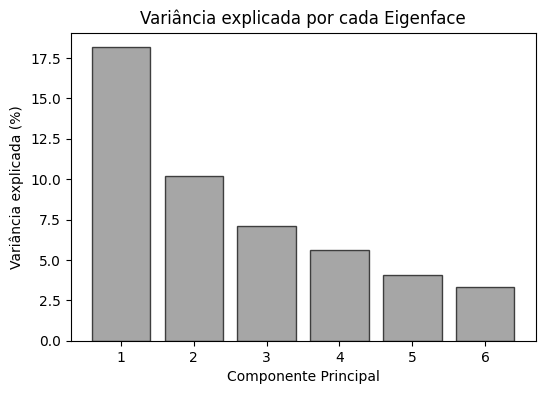

Variância explicada individual (%): [18.15 10.18  7.1   5.6   4.07  3.34]
Variância acumulada (%): [18.15 28.33 35.44 41.03 45.1  48.44]


In [ ]:
# Variância explicada por cada componente (em %)
explained_var = pca_estimator.explained_variance_ratio_

# Plot de barras
plt.figure(figsize=(6,4))
plt.bar(range(1, n_components+1), explained_var*100, alpha=0.7, color="gray", edgecolor="black")
plt.xlabel("Componente Principal")
plt.ylabel("Variância explicada (%)")
plt.title("Variância explicada por cada Eigenface")
plt.xticks(range(1, n_components+1))
plt.show()

print("Variância explicada individual (%):", np.round(explained_var*100, 2))
print("Variância acumulada (%):", np.round(np.cumsum(explained_var)*100, 2))


O gráfico mostra que, com as 6 eigenfaces extraídas, conseguimos capturar 48% da variabilidade estatística do dataset. Vamos então verificar quantas eigenfaces precisamos para abranger uma qtde eficiente do dataset:

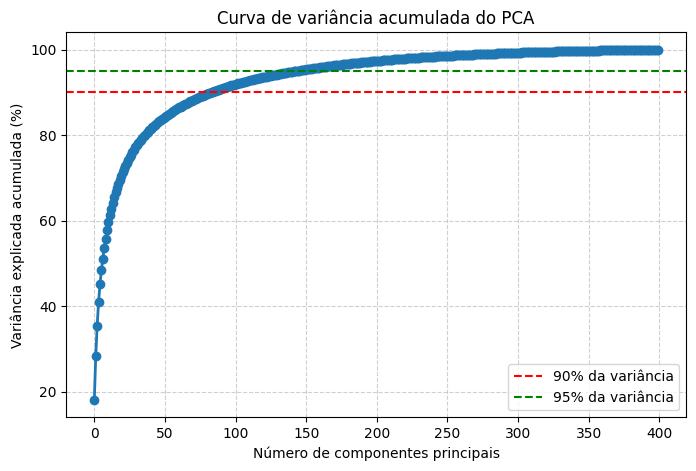

Número de componentes para >=90%: 84
Número de componentes para >=95%: 144


In [ ]:
from sklearn.decomposition import PCA

# PCA com todos os componentes possíveis
pca_full = PCA(n_components=min(n_samples, n_features), svd_solver="randomized", whiten=True, random_state=0)
pca_full.fit(faces_centered)

# Variância explicada acumulada
explained_cumsum = np.cumsum(pca_full.explained_variance_ratio_) * 100

# Plot
plt.figure(figsize=(8,5))
plt.plot(explained_cumsum, marker="o", linewidth=2)
plt.axhline(90, color="red", linestyle="--", label="90% da variância")
plt.axhline(95, color="green", linestyle="--", label="95% da variância")
plt.xlabel("Número de componentes principais")
plt.ylabel("Variância explicada acumulada (%)")
plt.title("Curva de variância acumulada do PCA")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Exibir quantos componentes são necessários para 90% e 95%
n90 = np.argmax(explained_cumsum >= 90) + 1
n95 = np.argmax(explained_cumsum >= 95) + 1
print(f"Número de componentes para >=90%: {n90}")
print(f"Número de componentes para >=95%: {n95}")


Fica evidente que conseguimos diminuir a dimensionalidade do problema - antes, cada imagem era representada por 4096 features, os pixels. agora, cada imagem pode ser representada em um espaço de 100 dimensões, sendo elas os pesos associados a cada eigenface - e, ainda assim, ser eficiente.

----------------------------------------------------------------------

**2) Non-negative components - NMF**

- Se aplica nos dados ORIGINAIS, não centralizados
- Apenas valores positivos

Tenta representar os dados como uma combinação aditiva de partes - decompõe  amatriz original em 2 matrizes menores, uma matriz de pesos e uma de componentes ("partes do rosto" aprendidas).

Cada componente extraído representa uma parte localizada (boca, óculos, olhos, nariz, etc.), e cada rosto do dataset pode ser reconstruído como uma combinação aditiva dessas partes, com pesos diferentes para cada componente

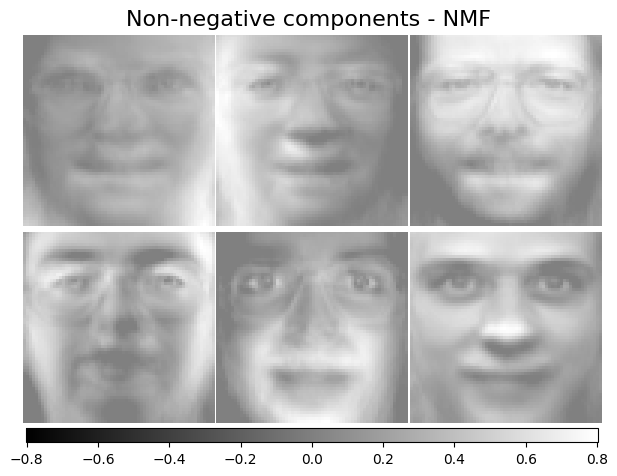

In [ ]:
nmf_estimator = decomposition.NMF(n_components=n_components, tol=5e-3)
nmf_estimator.fit(faces)  # original non- negative dataset
plot_gallery("Non-negative components - NMF", nmf_estimator.components_[:n_components])

--------------------------------------------------------------------------------

**3) Independent components - FastICA**
- Se aplica nos dados centralizados

Extrai padrões mais "localizados", isto é, partes mais específicas e independentes.

Ao contrário do PCA, o FastICA nos entrega "pedaços independentes" do dataset, que aí nos permitem "recuperar" as imagens originais combinando linearmente as associações desses pedaços independentes com seus pesos/coeficientes calculados pra cada imagem.

O resultado não será idêntico à imagem original, mas tendo componentes suficiente, é capaz de preservar os padrões essenciais que definem as imagens

Ex: cada componente, de certa forma, destaca mais alguma "região" da imagem, um destaca a região dos óculos, outro da boca, sombras laterais, e por aí vai. Assim, o algoritmo pode "recuperar" uma imagem próxima à original combinanddo os pedaçõs ponderados: a face X tem 0.8 do componente "óculos", 0.5 de sombra na região esquerda, e por aí vai

Esse algoritmo pode ser muito útil em uma aplicação de separação e filtragem de vozes em gravações, por exemplo.

/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


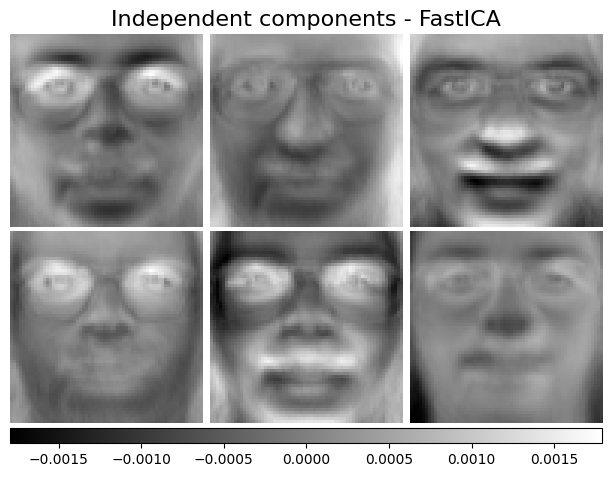

In [ ]:
ica_estimator = decomposition.FastICA(n_components=n_components, max_iter=400, whiten="arbitrary-variance", tol=15e-5)
ica_estimator.fit(faces_centered)
plot_gallery("Independent components - FastICA", ica_estimator.components_[:n_components])

--------------------------------------------------------------------------------

**4) Sparse components - MiniBatchSparsePCA**

- Se aplica nos dados centralizados

Funciona como uma variação do PCA, no qual cada componente depende de apenas alguns pixels mais relevantes para o contexto, ao invés de se basear em todos os pixels da imagem (no nosso caso, os 4096).

Daí vem o nome: o algoritmo extrai componentes esparsos do dataset.
Na prática, cada commponente destaca regiões localizadas da face, sendo mais fáceis de interpretar do que os padrões globais do PCA.

Além disso, utiliza pequenos lotes (batches) de dados por vez para treinar, resultando em um algoritmo mais escalável e eficaz para datasets muito grandes

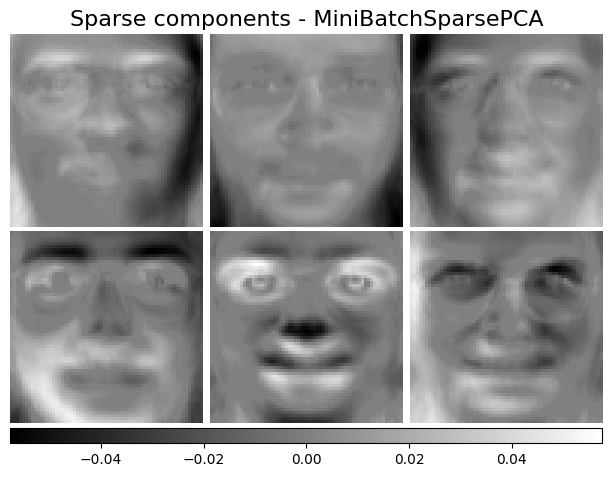

In [ ]:
batch_pca_estimator = decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.1, max_iter=100, batch_size=3, random_state=rng) # alpha = esparsividade, #max_iter = nº máx. de iterações pro algoritmo convergir e ajustar os pesos dos componentes
batch_pca_estimator.fit(faces_centered)
plot_gallery("Sparse components - MiniBatchSparsePCA", batch_pca_estimator.components_[:n_components],)

**5) Dictionary learning**

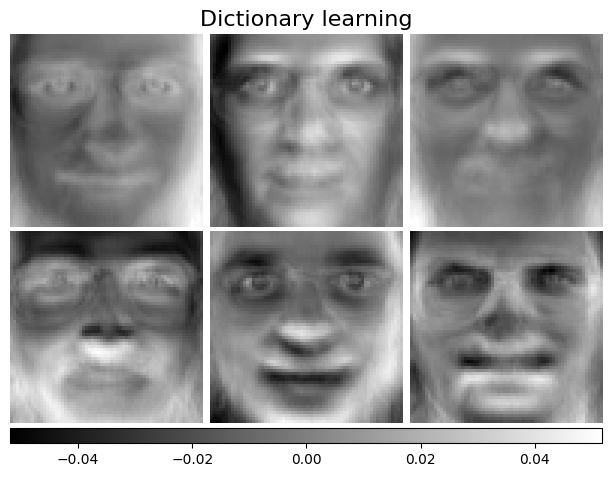

In [ ]:
batch_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components, alpha=0.1, max_iter=50, batch_size=3, random_state=rng
)
batch_dict_estimator.fit(faces_centered)
plot_gallery("Dictionary learning", batch_dict_estimator.components_[:n_components])

**6) Cluster centers - MiniBatchKMeans**











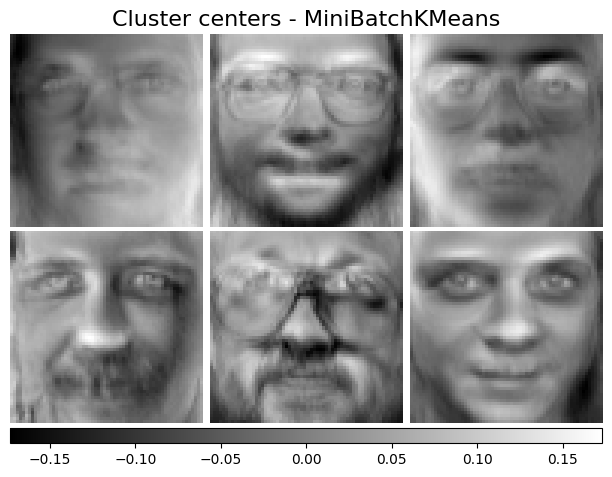

In [ ]:
kmeans_estimator = cluster.MiniBatchKMeans(
    n_clusters=n_components,
    tol=1e-3,
    batch_size=20,
    max_iter=50,
    random_state=rng,
)
kmeans_estimator.fit(faces_centered)
plot_gallery(
    "Cluster centers - MiniBatchKMeans",
    kmeans_estimator.cluster_centers_[:n_components],
)

**7) Factor Analysis components - FA**

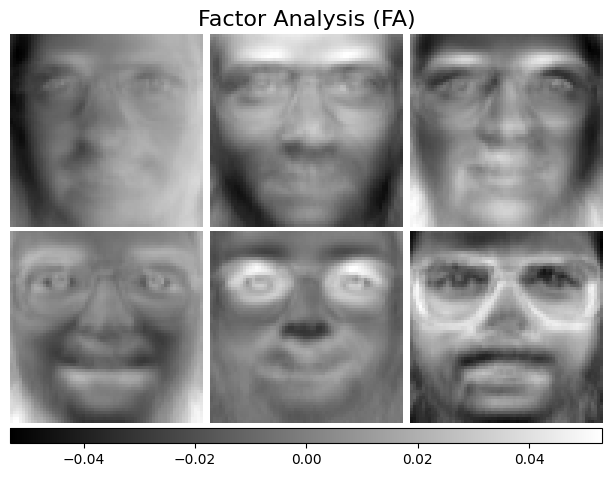

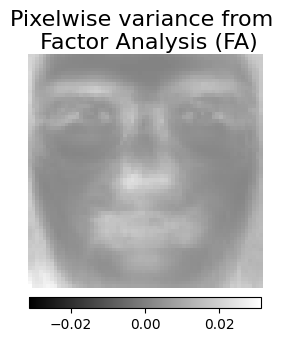

In [ ]:
fa_estimator = decomposition.FactorAnalysis(n_components=n_components, max_iter=20)
fa_estimator.fit(faces_centered)
plot_gallery("Factor Analysis (FA)", fa_estimator.components_[:n_components])

# --- Pixelwise variance
plt.figure(figsize=(3.2, 3.6), facecolor="white", tight_layout=True)
vec = fa_estimator.noise_variance_
vmax = max(vec.max(), -vec.min())
plt.imshow(
    vec.reshape(image_shape),
    cmap=plt.cm.gray,
    interpolation="nearest",
    vmin=-vmax,
    vmax=vmax,
)
plt.axis("off")
plt.title("Pixelwise variance from \n Factor Analysis (FA)", size=16, wrap=True)
plt.colorbar(orientation="horizontal", shrink=0.8, pad=0.03)
plt.show()

**DECOMPOSIÇÃO - DICTIONARY LEARNING**

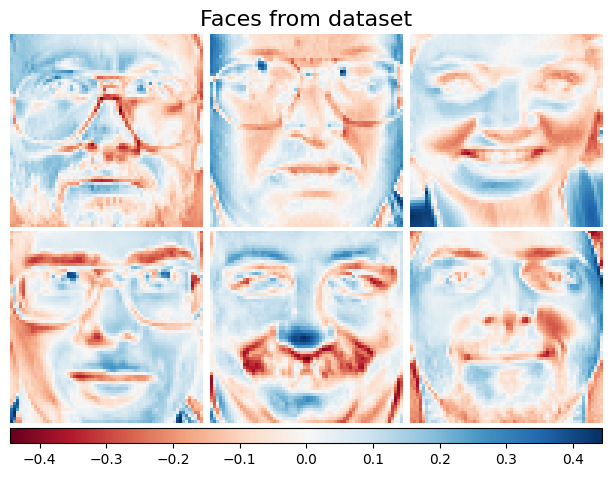

In [ ]:
plot_gallery("Faces from dataset", faces_centered[:n_components], cmap=plt.cm.RdBu)

**Dictionary learning - positive dictionary**

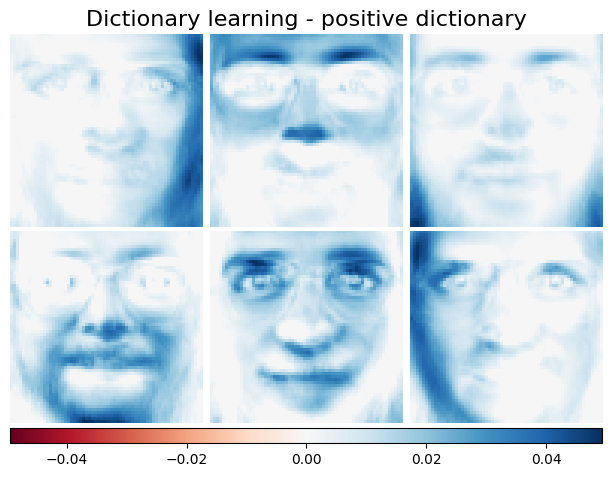

In [ ]:
dict_pos_dict_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    random_state=rng,
    positive_dict=True,
)
dict_pos_dict_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary",
    dict_pos_dict_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

**Dictionary learning - positive code**

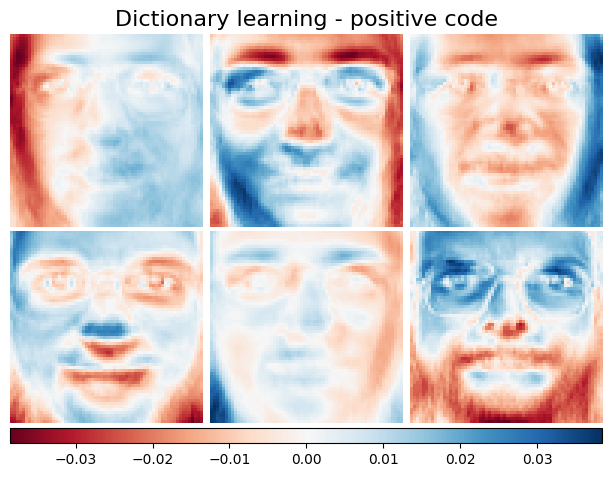

In [ ]:
dict_pos_code_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_code=True,
)
dict_pos_code_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive code",
    dict_pos_code_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)

**Dictionary learning - positive dictionary & code**

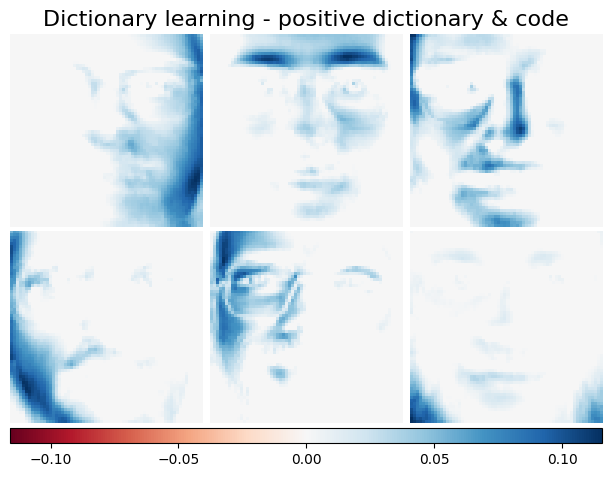

In [ ]:
dict_pos_estimator = decomposition.MiniBatchDictionaryLearning(
    n_components=n_components,
    alpha=0.1,
    max_iter=50,
    batch_size=3,
    fit_algorithm="cd",
    random_state=rng,
    positive_dict=True,
    positive_code=True,
)
dict_pos_estimator.fit(faces_centered)
plot_gallery(
    "Dictionary learning - positive dictionary & code",
    dict_pos_estimator.components_[:n_components],
    cmap=plt.cm.RdBu,
)